In [1]:
# Here i'll try 2 stage calculating of transform
# 1) Calculate rx, ry as Affine transform
# 2) Use rx, ry(from stage 1) to calc distortion transform

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2, suppress=True)

%matplotlib inline

In [2]:
lImg_fname = 'data/stars/test1.png'
rImg_fname = 'data/stars/test2.png'
# lImg_fname = 'data/stars/Stars-3072x2304-1.png'
# rImg_fname = 'data/stars/Stars-3072x2304-2.png'

In [3]:
lImg = Image.open(lImg_fname)
rImg = Image.open(rImg_fname)
l_data = lImg.load() # pixmap of lImg
r_data = rImg.load() # pixmap of rImg

In [4]:
w, h = width, height = lImg.size

In [5]:
x_c, y_c = (width) / 2., (height) / 2. # center coordinates

In [6]:
fname_640x480 = 'data/coords_640x480.txt'
# fname_3072x2304 = 'data/coords_3072x2304.txt'
fname = fname_640x480
# fname = fname_3072x2304
coords = np.loadtxt(fname)

In [7]:
lX = coords[:, 0] # leftX coordinates
lY = coords[:, 1] # leftY coordinates
rX = coords[:, 2] # rightX coordinates
rY = coords[:, 3] # rightY coordinates

N = coords.shape[0] # number of pairs of points
M = coords.shape[1] # lX, lY, rX, rY == 4

In [8]:
print 'Input coordinates from %r: \n' % fname, coords, '\n'

Input coordinates from 'data/coords_640x480.txt': 
[[ 128.  205.  185.  218.]
 [ 148.  159.  200.  170.]
 [ 222.  167.  272.  180.]
 [ 226.  211.  279.  222.]
 [ 272.  236.  322.  248.]
 [ 305.  259.  357.  268.]
 [ 366.  256.  418.  266.]] 



In [9]:
# Solve the system of linear equations via pseudo inversion

# Below lX, lY, rX, rY mean lX[i], lY[i], rX[i], rY[i]:
# rX = a*lX + b*lY + e + e_2*rX*(rX**2 + rY**2)**0.5
# rY = c*lX + d*lY + f + e_2*rY*(rX**2 + rY**2)**0.5

# xi = A*z + nu,      where:

# xi.T = rX[0], rY[0] ... rX[N-1], rY[N-1]
# z.T = a, b, c, d, e, f, e_2  -- 6 affine coeff-s + distortion coeff
# nu -- vector of inaccuracy (?) I don't use it right now

# A = [ # L = N-1   -- Last 
# lX[0] lY[0]  0     0      1  0  rX[0]*(rX[0]**2 + rY[0]**2)**0.5 ;
# 0     0      lX[0] lY[0]  0  1  rY[0]*(rX[0]**2 + rY[0]**2)**0.5 ;
# ...                                                          ... ;
# ...                                                          ... ;
# ...                                                          ... ;
# lX[L] lY[L]  0     0      1  0  rX[L]*(rX[L]**2 + rY[L]**2)**0.5 ;
# 0     0      lX[L] lY[L]  0  1  rY[L]*(rX[L]**2 + rY[L]**2)**0.5 . ]


In [10]:
xi = np.zeros(2*N)
z = np.zeros(7)
arr = np.zeros((2*N, 7)) # matrix A

In [11]:
for i in xrange(N): # fill the xi vector
    xi[2*i] = rX[i]
    xi[2*i + 1] = rY[i]

In [53]:
for i in xrange(N): # fill the A matrix
    r = np.sqrt((rX[i]-x_c)**2 + (rY[i]-y_c)**2)

    tmp = (rX[i] - x_c) * r
#     tmp = 0 # for simple affine6 algorithm!; comment out other tmps
    arr[2*i] = [lX[i], lY[i], 0, 0, 1, 0, tmp]
    
    tmp = (rY[i] - y_c) * r
    arr[2*i + 1] = [0, 0, lX[i], lY[i], 0, 1, tmp]


In [54]:
print 'xi = A*z + nu'
print 'xi:\n', xi
print 'A:\n', arr, '\n'


xi = A*z + nu
xi:
[ 185.  218.  200.  170.  272.  180.  279.  222.  322.  248.  357.  268.
  418.  266.]
A:
[[   128.      205.        0.        0.        1.        0.   -18465.41]
 [     0.        0.      128.      205.        0.        1.    -3009.18]
 [   148.      159.        0.        0.        1.        0.   -16670.93]
 [     0.        0.      148.      159.        0.        1.    -9724.71]
 [   222.      167.        0.        0.        1.        0.    -3688.2 ]
 [     0.        0.      222.      167.        0.        1.    -4610.25]
 [   226.      211.        0.        0.        1.        0.    -1835.87]
 [     0.        0.      226.      211.        0.        1.     -805.99]
 [   272.      236.        0.        0.        1.        0.       16.49]
 [     0.        0.      272.      236.        0.        1.       65.97]
 [   305.      259.        0.        0.        1.        0.     1716.82]
 [     0.        0.      305.      259.        0.        1.     1299.21]
 [   366.      2

In [55]:
pinv_arr = np.linalg.pinv(arr) # Calculate pseudo inverted A
z = np.dot(pinv_arr, xi)

In [56]:
np.set_printoptions(precision=8, suppress=True)
print 'Result Affine:'
print 'z:', z
np.set_printoptions(precision=2, suppress=True)

Result Affine:
z: [  0.94261793   0.0667408   -0.00859657   0.97575576  52.36882831
  18.82249077   0.00015763]


In [57]:
for i in xrange(width):
    for j in xrange(height):
        r, g, b = l_data[i, j]
        l_data[i, j] = r, 0, 0  # color lImg in red
        
        r, g, b = r_data[i, j]
        r_data[i, j] = 0, g, 0  # color rImg in green

In [58]:
l_data[x_c, y_c] = 255, 255, 255    # Mark the center
l_data[x_c-1, y_c] = 255, 255, 255
l_data[x_c+1, y_c] = 255, 255, 255
l_data[x_c, y_c-1] = 255, 255, 255
l_data[x_c, y_c+1] = 255, 255, 255

In [59]:
# Image.blend(lImg, rImg, alpha=0.5) # Initial blend

In [60]:
a = float(z[0])
b = float(z[1])
c = float(z[2])
d = float(z[3])
e = float(z[4])
f = float(z[5])
e_2 = float(z[6])
data = (a, b, e, c, d, f) # affine coefficients

In [61]:
# aff_rImg = rImg.transform(rImg.size, Image.AFFINE, data, 
#                resample=Image.BICUBIC)

# Image.blend(lImg, aff_rImg, alpha=0.5) # only affine transform

In [62]:
data = z
a = float(data[0])
b = float(data[1])
c = float(data[2])
d = float(data[3])
e = float(data[4])
f = float(data[5])
e_2 = float(data[6])

znam = a*d - b*c
inv_a = d / znam
inv_b = -b / znam
inv_c = -c / znam
inv_d = a / znam

In [66]:
def spec_transform(lx, ly, data=None):
    """Special transform: affine + distortion
    data = [a, b, c, d, e, f, e_2]
    lImg -> rImg"""
    
    rx = a*lx + b*ly + e
    ry = c*lx + d*ly + f
    
    r = np.sqrt((rx-x_c)**2 + (ry-y_c)**2)
    
    nx = a*lx + b*ly + e + e_2*(rx-x_c)*r
    ny = c*lx + d*ly + f + e_2*(ry-y_c)*r
    
    return (round(nx), round(ny))



In [67]:
def inv_transform(rx, ry, data=None):
    """Inverted Special transform: affine + distortion
    data = [a, b, c, d, e, f, e_2]
    right Img -> left Img"""
    
    r = np.sqrt((rx-x_c)**2 + (ry-y_c)**2)
    fac = 1 - e_2*r  # factor
    
    orig_x = (rx*fac - e)*inv_a + (ry*fac - f)*inv_b + e_2*r*x_c
    orig_y = (rx*fac - e)*inv_c + (ry*fac - f)*inv_d + e_2*r*y_c
    
    return (round(orig_x), round(orig_y))


In [68]:
coords_right = np.zeros((width, height, 2))

In [69]:
for i in xrange(width): #Calculating new (right) coordinates (Affine only)
    for j in xrange(height):
        rx, ry = spec_transform(i, j, z)
        coords_right[i, j, 0], coords_right[i, j, 1] = rx, ry
        

In [70]:
print 'Coords_right:\n', coords_right, '\n'


Coords_right:
[[[  38.    7.]
  [  38.    8.]
  [  38.    9.]
  ..., 
  [  72.  497.]
  [  72.  498.]
  [  72.  499.]]

 [[  39.    7.]
  [  39.    8.]
  [  39.    9.]
  ..., 
  [  73.  497.]
  [  73.  498.]
  [  73.  499.]]

 [[  40.    7.]
  [  40.    8.]
  [  40.    9.]
  ..., 
  [  74.  497.]
  [  74.  498.]
  [  74.  499.]]

 ..., 
 [[ 674.   -1.]
  [ 674.    0.]
  [ 674.    1.]
  ..., 
  [ 710.  495.]
  [ 710.  496.]
  [ 710.  497.]]

 [[ 675.   -1.]
  [ 675.   -0.]
  [ 675.    1.]
  ..., 
  [ 711.  495.]
  [ 711.  496.]
  [ 711.  497.]]

 [[ 676.   -1.]
  [ 676.   -0.]
  [ 676.    1.]
  ..., 
  [ 712.  495.]
  [ 712.  496.]
  [ 712.  497.]]] 



In [71]:
# Crop rect out of calculated right img
l_edge = max(coords_right[0, :, 0])
print 'l_edge:', l_edge

r_edge = min(coords_right[width-1, :, 0])
print 'r_edge:', r_edge

t_edge = max(coords_right[:, 0, 1])
print 't_edge:', t_edge

b_edge = min(coords_right[:, height-1, 1])
print 'b_edge:', b_edge

l_edge: 72.0
r_edge: 676.0
t_edge: 9.0
b_edge: 493.0


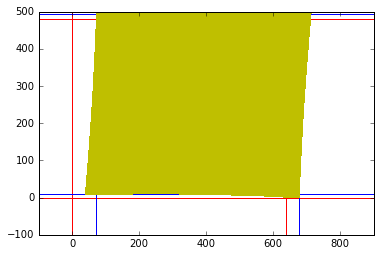

In [72]:
plt.plot(coords_right[:,:,0], coords_right[:,:,1], 'y,')

xmin, xmax = plt.xlim()
plt.xlim(xmin-100, xmax+100)
xmin, xmax = plt.xlim()

ymin, ymax = plt.ylim()

# Left image rect
left_x = [0, width-1]
left_y = [0, height-1]
plt.vlines(left_x, ymin, ymax, colors='r')
plt.hlines(left_y, xmin, xmax, colors='r')

# Right cropped img rect
right_x = [l_edge, r_edge]
right_y = [t_edge, b_edge]
plt.vlines(right_x, ymin, ymax, colors='b')
plt.hlines(right_y, xmin, xmax, colors='b')


plt.show()

In [73]:
# Edges (right spec_transformed img)
left = max(list(coords_right[0, :, 0]) + [0])
top = max(list(coords_right[:, 0, 1]) + [0])
right = min(list(coords_right[-1, :, 0]) + [width-1])
bottom = min(list(coords_right[:, -1, 1]) + [height-1])

In [74]:
print 'Edges (right spec_transformed img)'
print 'left', left
print 'top', top
print 'right', right
print 'bottom', bottom

# Corners of box:
# (left, top); (right, bottom)

Edges (right spec_transformed img)
left 72.0
top 9.0
right 639
bottom 479


In [75]:
nw = int(right+1 - left)
nh = int(bottom+1 - top)

print 'New size:', nw, nh

New size: 568 471


In [76]:
new_lImg = Image.new('RGB', size=(nw, nh))
new_rImg = Image.new('RGB', size=(nw, nh))
new_lImg_pix = new_lImg.load()
new_rImg_pix = new_rImg.load()

n_left_coords = np.zeros((nw, nh, 2))

In [77]:
left = int(left)
right = int(right)
top = int(top)
bottom = int (bottom)

# Let's calculate backwards our original coordinates 
# of the left image
for x in xrange(left, right+1):
    for y in xrange(top, bottom+1):
        orig_x, orig_y = inv_transform(x, y)
        
# Throw away points out of original left img area(box)
        if orig_x < 0:
            orig_x = 0
        if orig_y < 0:
            orig_y = 0
            
        if orig_x >= width:
            orig_x = width-1
        if orig_y >= height:
            orig_y = height-1
        
        n_left_coords[x-left, y-top, 0] = orig_x
        n_left_coords[x-left, y-top, 1] = orig_y
        
        new_lImg_pix[x-left, y-top] = l_data[orig_x, orig_y]
        new_rImg_pix[x-left, y-top] = r_data[x, y]


In [78]:
print n_left_coords

[[[  35.    2.]
  [  34.    3.]
  [  34.    4.]
  ..., 
  [   3.  456.]
  [   3.  457.]
  [   3.  458.]]

 [[  36.    2.]
  [  35.    3.]
  [  35.    4.]
  ..., 
  [   4.  456.]
  [   4.  457.]
  [   4.  458.]]

 [[  37.    2.]
  [  36.    3.]
  [  36.    4.]
  ..., 
  [   5.  456.]
  [   5.  457.]
  [   4.  458.]]

 ..., 
 [[ 599.    9.]
  [ 599.   10.]
  [ 599.   11.]
  ..., 
  [ 567.  459.]
  [ 566.  460.]
  [ 566.  461.]]

 [[ 600.    9.]
  [ 600.   10.]
  [ 599.   11.]
  ..., 
  [ 568.  459.]
  [ 567.  460.]
  [ 567.  461.]]

 [[ 601.    9.]
  [ 600.   10.]
  [ 600.   11.]
  ..., 
  [ 569.  459.]
  [ 568.  460.]
  [ 568.  461.]]]


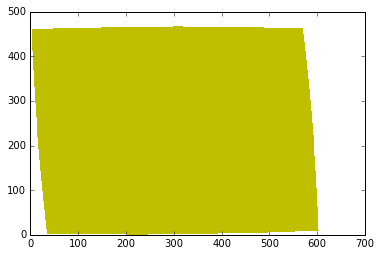

In [79]:
plt.plot(n_left_coords[:,:,0], n_left_coords[:,:,1], ',y')
plt.show()

In [80]:
t = n_left_coords
x_mask = (t[:,:,0] > 0) * (t[:,:,0] < width)
y_mask = (t[:,:,1] > 0) * (t[:,:,1] < height)
mask = x_mask * y_mask

In [81]:
print 'x_mask:\n', x_mask
print 'y_mask:\n', y_mask
print 'mask:\n', mask

x_mask:
[[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]]
y_mask:
[[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]]
mask:
[[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]]


In [82]:
x_ok, y_ok = np.where(mask)

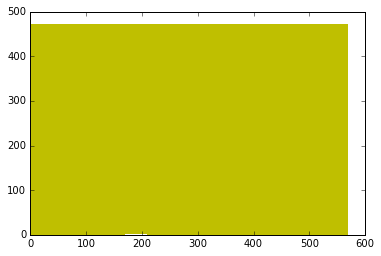

In [83]:

plt.plot(x_ok, y_ok, ',y')


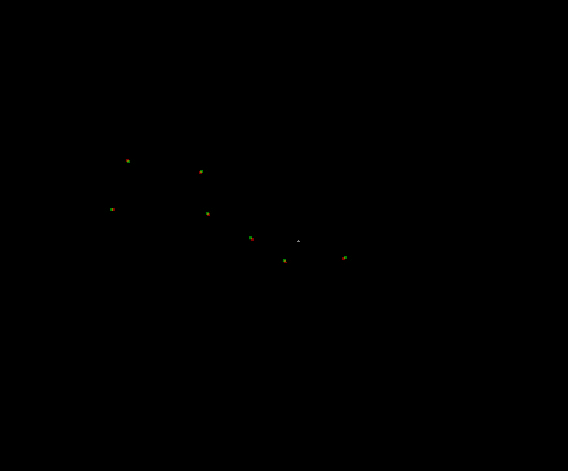

In [84]:
# Blend of affine transformed with distortion
Image.blend(new_lImg, new_rImg, alpha=0.5)